# Integração de Monte Carlo

## Importance sampling

O método de Monte Carlo é útil para integrar funções patológicas, como vimos acima. Entretanto, há situações onde mesmo este método não funciona muito bem. Um caso é quando o volume de integração é muito grande, com o integrando tendo valores altos concentrados em poucos locais. Outro caso é quando temos um integrando que contém uma divergência. Em ambos os casos, existem regiões problemáticas, que pouco contribuem para a integral (no primeiro caso) ou podem causar uma variância muito grande no resultado (no segundo caso).

Um exemplo de integral com integrando que diverge é

$$
I = \int_0^1 \frac{x^{-1/2}}{\mathrm{e}^x + 1}\ \mathrm{d}x.
$$

Esta integral aparece na teoria de Fermi do gases. O integrando diverge em $x = 0$, porém a integral tem valor finito. Vamos fazer o gráfico do integrando no intervalo de integração.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

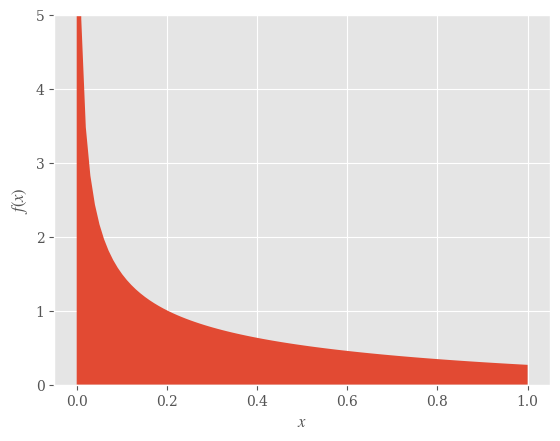

In [3]:
def f(x):
    return x**-0.5 / (np.exp(x) + 1)

x = np.linspace(0.0 + 1e-10, 1.0, 100)

fig, ax = plt.subplots()
ax.fill_between(x, f(x), 0.0)
ax.set_ylabel('$f(x)$')
ax.set_xlabel('$x$')
ax.set_ylim(0.0, 5.0)
plt.show()

Vejamos como a integral usando o método de Monte Carlo se comporta. Usando $N=100$, vamos repetir esta integral 10 vezes. Repare como, de vez em quando, o resultado cai muito longe da média dos outros, fora do esperado pelo desvio padrão.

In [4]:
def integral_MC(N):
    a = 0.0
    b = 1.0
    soma = 0.0
    soma2 = 0.0
    for _ in range(N):
        xi = np.random.uniform(a, b)
        fxi = f(xi)
        soma += fxi
        soma2 += fxi**2
    med_f = soma / N
    sigma_f = np.sqrt(soma2 / N - med_f**2)
    I = (b - a) * med_f
    sigma = (b - a) * sigma_f / np.sqrt(N)
    return I, sigma
    
    
np.random.seed(1)
N = 100
b = 1.0
a = 0.0

for _ in range(10):
    I, sigma = integral_MC(N)
    print(f'I = {I:.4f}, sigma = {sigma:.4}')

I = 1.3176, sigma = 0.4689
I = 0.9369, sigma = 0.09394
I = 0.9132, sigma = 0.2499
I = 0.7345, sigma = 0.061
I = 0.9275, sigma = 0.1209
I = 0.9003, sigma = 0.1034
I = 0.8631, sigma = 0.1206
I = 0.7299, sigma = 0.08216
I = 0.7340, sigma = 0.05882
I = 0.8237, sigma = 0.07073


Vejamos como ocorre e a convergência da integral com $N$ variando de 500 a 100 mil. Este gráfico servirá de referência mais adiante.

In [5]:
np.random.seed(1234)

# 10^2 até 10^5 em 50 intervalos logarítmicos.
# O método .astype(t) converte o array para o tipo t.
# M experimentos com N medidas cada.
M = 50
lista_N = np.logspace(2, 5, M)
lista_I = np.zeros(M)
lista_sigma = np.zeros(M)

a = 0.0
b = 1.0

for i in range(M):
    N = int(lista_N[i])
    lista_I[i], lista_sigma[i] = integral_MC(N)

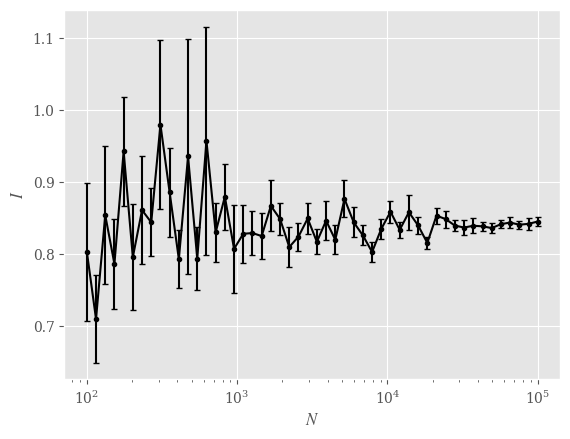

In [6]:
fig, ax = plt.subplots()
ax.errorbar(lista_N, lista_I, yerr=lista_sigma,
            ls='-', marker='.', capsize=2, color='k')
ax.set_xscale('log')
ax.set_ylabel('$I$')
ax.set_xlabel('$N$')
plt.show()

Algumas vezes a integral tem um valor muito fora do esperado, o que faz com que o desvio padrão seja muito grande mesmo com uma quantidade grande de pontos, como mostram as barras de erro no gráfico acima. Existe uma maneira de fugir deste problema. Vamos modificar ligeiramente a integral, da forma

\begin{align}
I &= \int_a^b f(x)\ \mathrm{d}x \\
&= \int_a^b p(x) \frac{f(x)}{p(x)}\ \mathrm{d}x \\
g(x) &\equiv \frac{f(x)}{p(x)} \\
\implies I &= \int_a^b p(x) g(x)\ \mathrm{d}x.
\end{align}

Considere que a função $p(x)$ está normalizada no intervalo de integração, isto é, $\int_a^b p(x)\ \mathrm{d}x = 1$. Neste caso, a integral agora é a média da função $g(x)$ ponderada pelo peso $p(x)$, denotada por $\langle g(x) \rangle_{p}$.

\begin{align}
I &= \langle g(x) \rangle_{p} = \int_a^b p(x) g(x)\ \mathrm{d}x.
\end{align}

Esta fórmula é análoga à que chegamos anteriormente, que relaciona a integral ao valor médio, mas agora temos que usar uma média ponderada. Com isso, podemos "trapacear" e fugir dos casos problemáticos, desde que escolhamos um peso $p(x)$ adequado.

Mas, como calculamos a média ponderada? Vamos sortear $N$ pontos $x_i$ de forma não uniforme, com probabilidade $p(x)\,\mathrm{d}x$ de caírem no intervalo $x$ a $x + \mathrm{d}x$. Então, esses $N$ pontos são uma descrição aproximada de $p(x)$, com mais pontos acumulados nos lugares onde $p(x)$ é maior. Uma maneira de visualizar esta descrição aproximada é fazer um historgrama de pontos: a forma do histograma será aproximadamente a mesma de $p(x)$.

Matematicamente, dizemos que a amostragem nos pontos $x_i$ aproxima o peso $p(x)$ por funções impulso, tal que

$$
p(x) \approx \frac 1 N \sum_{i=0}^{N-1} \delta(x - x_i),
$$

onde $\delta(x - x_i)$ é a distribuição delta de Dirac, que é diferente de zero somente em $x = x_i$, e a sua integral sobre todo o domínio é igual a 1. Assim, a média ponderada fica

\begin{align}
I &= \int_a^b p(x) g(x)\ \mathrm{d}x \\
&\approx \int_a^b \frac 1 N \sum_{i=0}^{N-1} \delta(x - x_i) g(x)\ \mathrm{d}x \\
&\approx \frac 1 N \sum_{i=0}^{N-1} \int_a^b \delta(x - x_i) g(x)\ \mathrm{d}x \\
&\approx \frac 1 N \sum_{i=0}^{N-1} g(x_i).
\end{align}

No último passo, usamos a [propriedade da filtragem](https://pt.wikipedia.org/wiki/Delta_de_Dirac#Propriedade_da_Filtragem) da delta de Dirac. Ficamos finalmente com

$$
I = \int_a^b f(x)\ \mathrm{d}x \approx \frac 1 N \sum_{i=0}^{N-1} \frac{f(x_i)}{p(x_i)},
$$

com $x_i$ tomados no intevalo $[a, b]$ com uma probabilidade dada por $p(x)$.

Esta é a fórmula fundamental do método *Importance Sampling*. Veja que ela é quase igual à que vínhamos usando, mas lembre-se de que a amostragem de números aleatórios não é uniforme!

Caso o peso seja uma função $w(x)$ não normalizada, podemos simplesmente fazer

\begin{align}
p(x) &= \frac{w(x)}{\int_a^b w(x)\ \mathrm{d}x} \\
\implies I &\approx \frac{\int_a^b w(x)\ \mathrm{d}x}{N} \sum_{i=0}^{N-1} \frac{f(x_i)}{w(x_i)}.
\end{align}

Verifique que se fizermos $w(x) = 1$, implicando numa probabilidade constante, ficamos com a regra da média aritmética usual.

Não vamos fazer a demonstração, mas a incerteza é dada em termos do desvio padrão da amostragem da função

\begin{align}
\sigma_{f,p}^2 &= \left\langle \left( \frac{f(x)}{p(x)}\right)^2 \right\rangle_p - \left\langle \frac{f(x)}{p(x)} \right\rangle_p^2\\
&= \frac 1 N \sum_{i=0}^{N-1} \left(\frac{f(x_i)}{p(x_i)}\right)^2 - \left( \frac 1 N \sum_{i=0}^{N-1} \frac{f(x_i)}{p(x_i)} \right)^2 \\
\sigma &= \frac{\sigma_{f,p}}{\sqrt N}.
\end{align}

### Exemplo

Vamos usar o método *importance sampling* para evitar a divergência na integral

$$
I = \int_0^1 \frac{x^{-1/2}}{\mathrm{e}^x + 1}\ \mathrm{d}x.
$$

A causa da divergência é o termo $x^{-1/2}$, que tende a infinito quando $x \to 0$. Se escolhermos $w(x) = x^{-1/2}$, ficamos com

\begin{align}
\frac{f(x)}{w(x)} &= f(x)\frac{1}{w(x)} \\
&= \frac{x^{-1/2}}{\mathrm{e}^x + 1}\frac{1}{x^{-1/2}} \\
&= \frac{1}{\mathrm{e}^x + 1}.
\end{align}

Esta função é muito mais bem comportada, e não irá causar os problemas vistos na abordagem uniforme. Agora, lembre que precisamos arrumar um jeito de sortear números aleatórios com distribuição de probabilidade dada pelo peso $w(x)$. Normalizando o peso,

\begin{align}
p(x) &= \frac{x^{-1/2}}{\int_0^1 x^{-1/2}\ \mathrm{d}x} \\
&= \frac 1 2 x^{-1/2},
\end{align}

ou seja, $p(x)$ é uma lei de potência. É possível gerar números aleatórios não-uniformes com base numa distribuição uniforme, veja a seção 10.1.5 do Computational Physics de Mark Newman. Neste caso em particular, vamos usar a função do numpy `np.random.power()`. Veja também que esta lei de potência gera números aleatórios no intervalo $[0, 1]$, o que por sorte é o intervalo que estamos interessados. É possível mudar este intervalo, por exemplo, usando [`scipy.stats.powerlaw()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.powerlaw.html#scipy-stats-powerlaw), mas não vamos nos preocupar com isso aqui. Existem várias outras distribuições, [veja a documentação](https://numpy.org/doc/stable/reference/random/generator.html#distributions).

Precisamos passar como argumento para a função `power()` um valor $\alpha$ tal que $p(x) = \alpha x^{\alpha-1}$, conforme indica a documentação. Logo, no nosso caso $\alpha = \frac 1 2$. Vamos testar a distribuição.

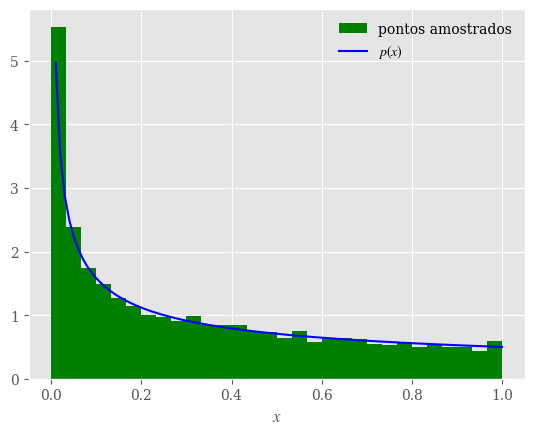

In [7]:
def p(x):
    return 0.5 / np.sqrt(x)

N = 10000
alpha = 0.5
xp = np.zeros(N)
for i in range(N):
    xp[i] = np.random.power(alpha)

fig, ax = plt.subplots()
ax.hist(xp, range=[0, 1], color='green', bins=30, density=True, label=r'pontos amostrados')

# Função analítica
x = np.linspace(a, b, 100)[1:] #removendo x = 0
ax.plot(x, p(x), 'b-', label=r'$p(x)$')

ax.set_xlabel(r'$x$')
ax.legend(frameon=False)
plt.show()

Os pontos amostrados com mais frequência são os mais importantes, quer dizer, pesam mais na média ponderada, por isso o nome do método. A função nestes lugares é avaliada de forma mais precisa, o que melhora a estatística (ou melhor, diminui a incerteza nos cálculos).

Calculamos facilmente a integral usando

$$
g(x) = \frac{f(x)}{p(x)} = \frac{2}{\mathrm{e}^x + 1}.
$$

#### Exercício

Calcule a integral usando o método *importance sampling*, e coloque o resultado no mesmo gráfico que o o resultado do método MC tradicional.

In [41]:
def g(x):
    return 2/(np.exp(x)+1)

def p(x):
    return np.exp(x) + 1

def f(x):
    return 2

N = 1000
alpha = 1/2
x = np.zeros(N)
for i in range(N):
    x[i] = np.random.power(alpha)

I = (1/N) * np.sum(g(x))

sig_fp = np.sqrt((1/N) * np.sum((g(x))**2) - ((1/N)*np.sum((g(x))))**2)
sig = sig_fp/np.sqrt(N)

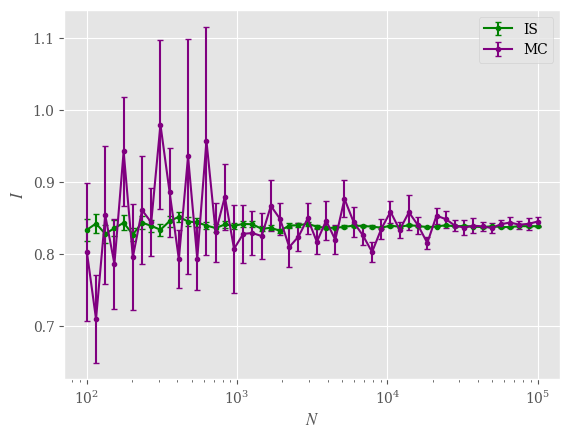

In [42]:
def integral_IS(N,func) -> tuple:

    x = np.zeros(N)
    for i in range(N):
        x[i] = np.random.power(alpha)

    I = (1/N) * np.sum(func(x))

    sig_fp = (1/N) * np.sum((func(x))**2) - ((1/N)*np.sum((func(x))))**2
    sig = np.sqrt(sig_fp)/np.sqrt(N)

    return I, sig

M = 50
NN = np.logspace(2,5,M)

Integrais = np.zeros(M)
Erro = np.zeros(M)

for i in range(M):
    Integrais[i] = integral_IS(int(NN[i]),g)[0]
    Erro[i] = integral_IS(int(NN[i]),g)[1]

fig, ax = plt.subplots(1,1)

ax.errorbar(NN,Integrais, yerr=Erro, ls="-", marker = ".", capsize=2, color = "green", label = "IS")
ax.errorbar(lista_N, lista_I, yerr=lista_sigma,ls='-', marker='.', capsize=2, color='purple', label = "MC")

ax.set_xscale("log")
ax.set_ylabel('$I$')
ax.set_xlabel('$N$')
ax.legend()
plt.show()

A diferença é brutal, usando *importance sampling* chegamos de 10 a 100 vezes mais rapidamente a uma determinada incerteza para esta integral em particular. A desvantagem é que precisamos gerar números aleatórios com uma distribuição $p(x)$ tal que as patologias do integrando desapareçam, o que nem sempre temos disponível nas bibliotecas.